

# DDPM using the three middle slices of T2 FlAIR images from The Dallas Lifespan Brain Study

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

## Setup imports

In [1]:
import os
import shutil
import tempfile
import time
import glob

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

#print_config()

In [2]:
DEVICE_TYPE = "cuda:1"

In [3]:
ROOT_DIR = "/home/fehrdelt/bettik/"
#ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"



In [4]:
set_determinism(0)

In [5]:
""" input_folder = ROOT_DIR+"datasets/Dallas_T2_FLAIR_extracted_brain_registered/"
output_folder = ROOT_DIR+"datasets/Dallas_T2_FLAIR_extracted_brain_registered_rotated/"

# rotate 90 deg
for file in tqdm(os.listdir(input_folder)):
    if file.endswith(".nii") or file.endswith(".gz"):
        # Load the image
        image_path = os.path.join(input_folder, file)
        image = nib.load(image_path)
        image_data = image.get_fdata()

        #file_mask = file.replace("adc.nii.gz", "msk.nii.gz")
        #mask_path = os.path.join(input_folder_masks, file_mask)
        #mask = nib.load(mask_path)
        #mask_data = mask.get_fdata()

        # Rotate the image data
        rotated_image_data = np.rot90(image_data, k=1, axes=(0, 1))
        #rotated_mask_data = np.rot90(mask_data, k=1, axes=(0, 1))

        # Create a new NIfTI image with the rotated data
        empty_header = nib.Nifti1Header()
        rotated_image = nib.Nifti1Image(rotated_image_data, affine=np.eye(4), header=empty_header)
        #rotated_mask = nib.Nifti1Image(rotated_mask_data, affine=np.eye(4), header=empty_header)
        #rotated_image = nib.Nifti1Image(rotated_data, affine=image.affine, header=empty_header)

        # Save the rotated image to the output folder
        rotated_image_path = os.path.join(output_folder, file)
        #rotated_mask_path = os.path.join(rotated_output_folder_masks, file_mask)
        nib.save(rotated_image, rotated_image_path)
        #nib.save(rotated_mask, rotated_mask_path) """

' input_folder = ROOT_DIR+"datasets/Dallas_T2_FLAIR_extracted_brain_registered/"\noutput_folder = ROOT_DIR+"datasets/Dallas_T2_FLAIR_extracted_brain_registered_rotated/"\n\n# rotate 90 deg\nfor file in tqdm(os.listdir(input_folder)):\n    if file.endswith(".nii") or file.endswith(".gz"):\n        # Load the image\n        image_path = os.path.join(input_folder, file)\n        image = nib.load(image_path)\n        image_data = image.get_fdata()\n\n        #file_mask = file.replace("adc.nii.gz", "msk.nii.gz")\n        #mask_path = os.path.join(input_folder_masks, file_mask)\n        #mask = nib.load(mask_path)\n        #mask_data = mask.get_fdata()\n\n        # Rotate the image data\n        rotated_image_data = np.rot90(image_data, k=1, axes=(0, 1))\n        #rotated_mask_data = np.rot90(mask_data, k=1, axes=(0, 1))\n\n        # Create a new NIfTI image with the rotated data\n        empty_header = nib.Nifti1Header()\n        rotated_image = nib.Nifti1Image(rotated_image_data, affine=np

## Setup Dallas Healthy Lifespan ADC Dataset and training and validation dataloaders

2D 128x128 slices of 3D ADC volumes

In [6]:
IMAGE_SIZE = 128

In [7]:
train_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/T2_FLAIR_Dallas/train.csv")
train_images_path = []

with open(train_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):
        #print(line)
        train_images_path.append(ROOT_DIR+line[0])

val_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/T2_FLAIR_Dallas/val.csv")
val_images_path = []

with open(val_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        val_images_path.append(ROOT_DIR+line[0])

test_reconstruction_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/T2_FLAIR_Dallas/test.csv")
test_reconstruction_images_path = []

with open(test_reconstruction_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_reconstruction_images_path.append(ROOT_DIR+line[0])


0it [00:00, ?it/s]

762it [00:00, 5568.89it/s]
95it [00:00, 1361.37it/s]
96it [00:00, 1464.54it/s]


In [8]:
""" test_unhealthy_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_aini-stroke_unhealthy_test/ADC_aini-stroke_unhealthy_test.csv")
test_unhealthy_images_path = []

with open(test_unhealthy_csv, mode='r') as file:
    reader = csv.reader(file)
    for line in tqdm(reader):

        test_unhealthy_images_path.append(ROOT_DIR+line[0]) """

' test_unhealthy_csv = os.path.join(ROOT_DIR, "Code/data_splits_lists/ADC_aini-stroke_unhealthy_test/ADC_aini-stroke_unhealthy_test.csv")\ntest_unhealthy_images_path = []\n\nwith open(test_unhealthy_csv, mode=\'r\') as file:\n    reader = csv.reader(file)\n    for line in tqdm(reader):\n\n        test_unhealthy_images_path.append(ROOT_DIR+line[0]) '

In [9]:
#train_datalist = sorted(train_images_path)
train_datalist = train_images_path

#val_datalist = sorted(val_images_path)
val_datalist = val_images_path

#val_datalist = sorted(val_images_path)
test_reconstruction_datalist = test_reconstruction_images_path

#test_unhealthy_datalist = test_unhealthy_images_path

batch_size = 64 #64
num_workers = 4


In [10]:
class Get2DSlice(transforms.Transform):
    """
    Fetch the middle slice of a 3D volume.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.offset = offset

    def __call__(self, data):
        #print(data.shape)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.offset]

In [11]:
class Get2DSliceWithRandomOffset(transforms.RandomizableTransform):
    """
    Will return the middle slice with a random offset in addition to the specified fixed offset.
    Args:
        axis: The axis along which to slice the volume. 0 for axial, 1 for coronal, 2 for sagittal.
        offset : Offset the index by a specified amount (default=0)
    """

    def __init__(
        self,
        axis: int = 0,
        fixed_offset: int=0
    ):
        super().__init__()
        self.axis = axis
        self.fixed_offset = fixed_offset
        self.rand_offset = 0


    def randomize(self):
        super().randomize(None)
        self.rand_offset = random.randint(-1, 1)

    def __call__(self, data):
        #print(data.shape)
        self.randomize()

        #print(self.rand_offset)
        if self.axis==0:
            return data[:, data.shape[1]//2+self.fixed_offset+self.rand_offset,:,:]
        elif self.axis==1:
            return data[:, :,data.shape[2]//2+self.fixed_offset+self.rand_offset,:]
        elif self.axis==2:
            return data[:, :, :,data.shape[3]//2+self.fixed_offset+self.rand_offset]

In [12]:

train_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        transforms.RandAffine(prob=0.2, rotate_range=(0.15, 0.15, 0.15)),#+- 0.15 radians for each axis
        Get2DSliceWithRandomOffset(axis=2, fixed_offset=5), #28
        #transforms.NormalizeIntensity(),
        transforms.ScaleIntensity(minv=0,maxv=1),
        #transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandScaleCrop(roi_scale=0.9, max_roi_scale=1.1, random_size=True),
        transforms.Resize(spatial_size=(128, 128)),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms) #TODO datalist[:batch_size] for debugging purposes, remove later
train_loader = DataLoader(
    #collate_fn=pad_list_data_collate: any tensors are centrally padded to match the shape of the biggest tensor in each dimension
    train_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True, collate_fn=pad_list_data_collate
)



Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [07:40<00:00,  1.65it/s]


In [13]:


val_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=5),  # 28
        #transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        #transforms.NormalizeIntensity(),
        transforms.ScaleIntensity(minv=0,maxv=1),
        transforms.Resize(spatial_size=(128, 128)),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [01:04<00:00,  1.48it/s]


In [14]:



test_reconstruction_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2, offset=5),
        #transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        #transforms.NormalizeIntensity(),
        transforms.ScaleIntensity(minv=0,maxv=1),
        transforms.Resize(spatial_size=(128, 128)),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_reconstruction_ds = CacheDataset(data=test_reconstruction_datalist, transform=test_reconstruction_transforms)
test_reconstruction_loader = DataLoader(
    test_reconstruction_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
)


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [01:01<00:00,  1.55it/s]


In [18]:
""" test_unhealthy_transforms = transforms.Compose(
    [
        transforms.LoadImage(),
        transforms.EnsureChannelFirst(),
        Get2DSlice(axis=2),
        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),
    ]
)
test_unhealthy_ds = CacheDataset(data=test_unhealthy_datalist, transform=test_unhealthy_transforms)
test_unhealthy_loader = DataLoader(
    test_unhealthy_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True
) """

' test_unhealthy_transforms = transforms.Compose(\n    [\n        transforms.LoadImage(),\n        transforms.EnsureChannelFirst(),\n        Get2DSlice(axis=2),\n        transforms.ScaleIntensityRange(a_min=0.0, a_max=4000.0, b_min=0.0, b_max=1.0, clip=True),\n        transforms.ResizeWithPadOrCrop(spatial_size=(128, 128)),\n    ]\n)\ntest_unhealthy_ds = CacheDataset(data=test_unhealthy_datalist, transform=test_unhealthy_transforms)\ntest_unhealthy_loader = DataLoader(\n    test_unhealthy_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True\n) '

### Visualisation of the training images

batch shape: torch.Size([64, 1, 128, 128])


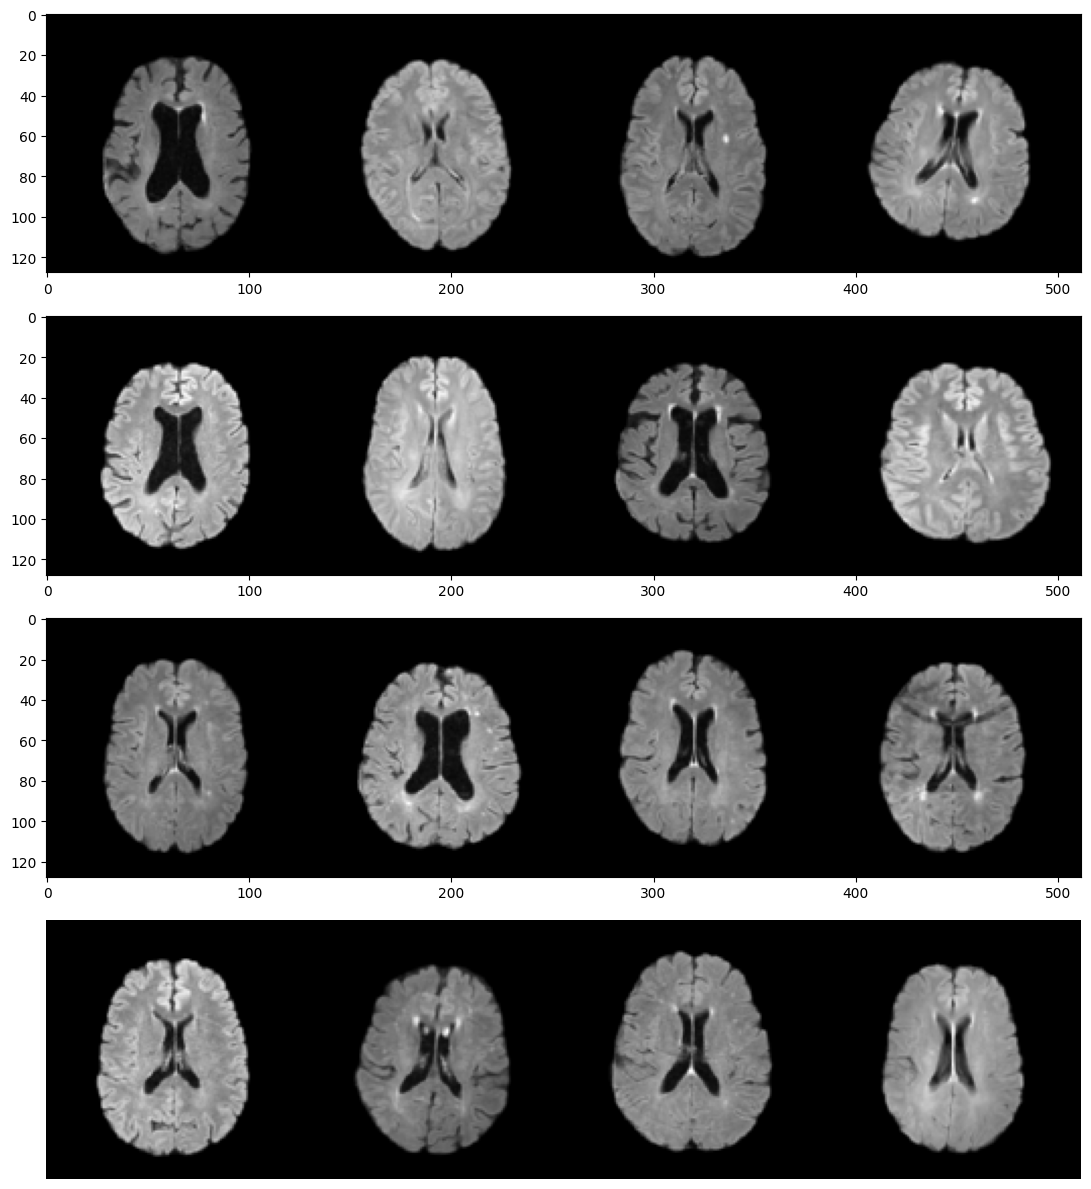

In [15]:

for i, batch in enumerate(train_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [16]:

for i, batch in enumerate(val_loader):
    #print(i)
    if i==2:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


batch shape: torch.Size([64, 1, 128, 128])


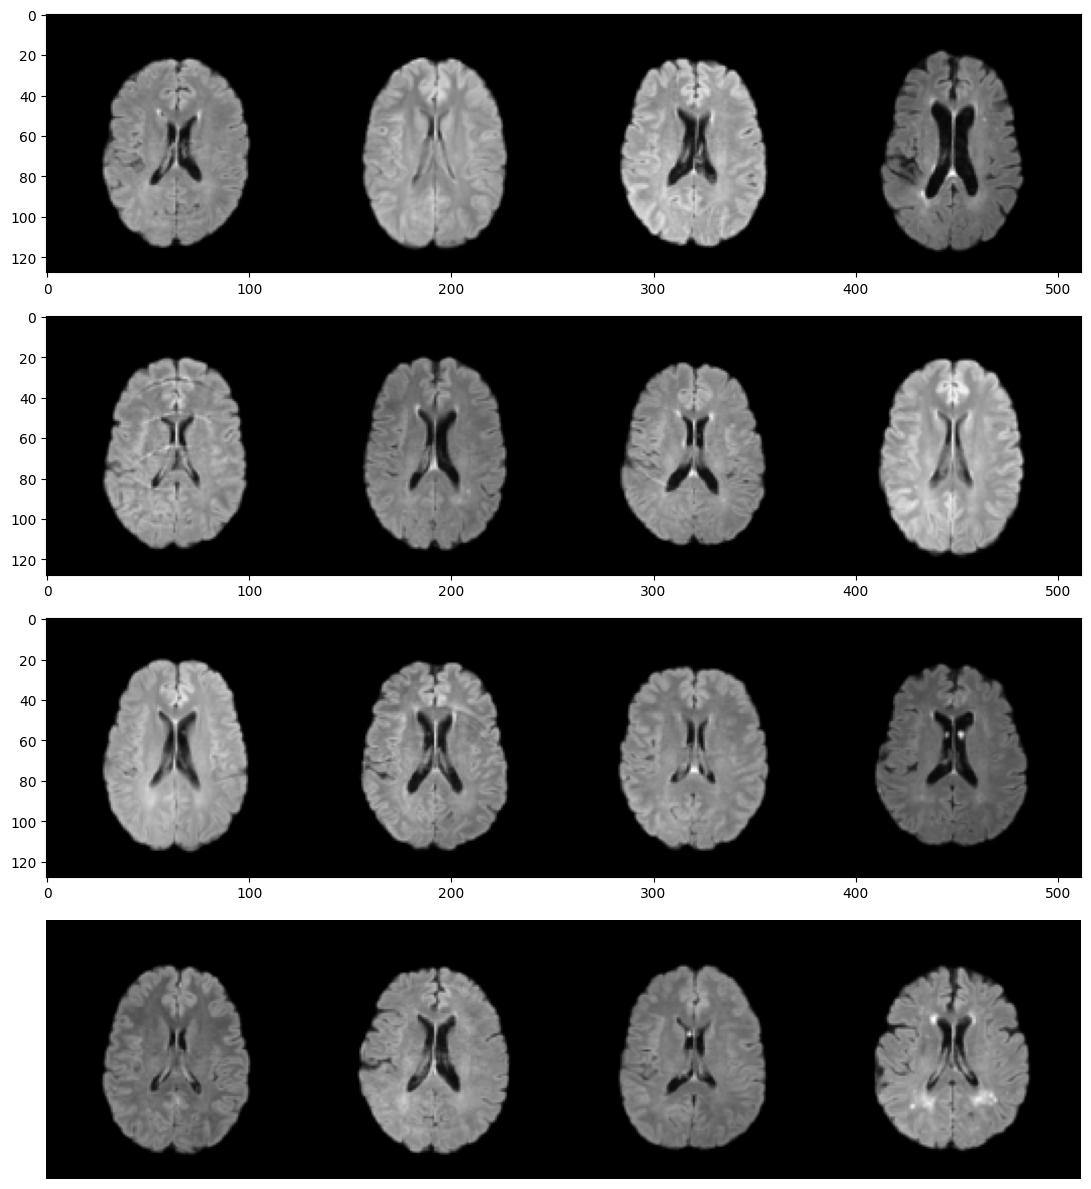

In [17]:

for i, batch in enumerate(test_reconstruction_loader):
    #print(i)
    if i==0:
     
        print(f"batch shape: {batch.shape}")
        image_visualisation0 = torch.cat(
            [batch[0, 0], batch[1, 0], batch[2, 0], batch[3, 0]], dim=1
        )
        image_visualisation1 = torch.cat(
            [batch[4, 0], batch[5, 0], batch[6, 0], batch[7, 0]], dim=1
        )
        image_visualisation2 = torch.cat(
            [batch[8, 0], batch[9, 0], batch[10, 0], batch[11, 0]], dim=1
        )
        image_visualisation3 = torch.cat(
            [batch[12, 0], batch[13, 0], batch[14, 0], batch[15, 0]], dim=1
        )
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,figsize=(12, 12))
        
        ax0.imshow(image_visualisation0, cmap="gray")
        ax1.imshow(image_visualisation1, cmap="gray")
        ax2.imshow(image_visualisation2, cmap="gray")
        ax3.imshow(image_visualisation3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [20]:
device = torch.device(DEVICE_TYPE)
num_train_timesteps = 1000

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=(0, 128, 128),
)
model.to(device)

num_train_timesteps = 1000
scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training
Here, we are training our model for 75 epochs (training time: ~50 minutes).

In [21]:
tensorboard_folder = ROOT_DIR+"Code/Tensorboard/Experiment_2-1/"
if not os.path.exists(tensorboard_folder):
    os.makedirs(tensorboard_folder)

In [22]:
writer = SummaryWriter(tensorboard_folder)

max_epochs = 6000
val_interval = 3
epoch_loss_list = []
val_epoch_loss_list = []

best_val_epoch_loss = np.inf
best_val_epoch = 0

scaler = GradScaler(DEVICE_TYPE)
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type=DEVICE_TYPE, enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        epoch_len = len(train_ds)
        

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    epoch_loss_list.append(epoch_loss / (step + 1))
    #writer.add_scalar("train_loss", epoch_loss / (step + 1), epoch)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(device)
            with torch.no_grad(), autocast(device_type=DEVICE_TYPE, enabled=True):
                noise = torch.randn_like(images).to(device)
                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()

            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
        #writer.add_scalar("val_loss", val_epoch_loss / (step + 1), epoch)   # moi

        if val_epoch_loss < best_val_epoch_loss:
            best_val_epoch_loss = val_epoch_loss
            best_val_epoch = epoch + 1
            #torch.save(
            #    model.state_dict(),
            #    os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "Experiment_2-1_T2_FLAIR_best_metric_model_dallas_3slices_per_patient.pth"),
            #)
            print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current val loss: {val_epoch_loss:.4f}"
                f"\nbest val loss: {best_val_epoch_loss:.4f}"
                f" at epoch: {best_val_epoch}"
            )
            #with open(os.path.join(tensorboard_folder, "best_epoch.txt"), "w") as f:
            #    f.write(
            #        f"best val loss: {best_val_epoch_loss:.4f} at epoch: {best_val_epoch}"
            #    )

        """
        if (epoch + 1) % (val_interval*4) == 0:
            # Sampling image during training
            noise = torch.randn((1, 1, IMAGE_SIZE, IMAGE_SIZE))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast(device_type=DEVICE_TYPE, enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
        """

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:  67%|████████▋    | 8/12 [00:51<00:25,  6.38s/it, loss=0.987]


KeyboardInterrupt: 

In [25]:
print(best_val_epoch)

762


In [19]:
model.load_state_dict(torch.load(os.path.join(ROOT_DIR+"Code/Best_models/2d_ddpm_tutorial", "Experiment_2-1_T2_FLAIR_best_metric_model_dallas_3slices_per_patient.pth"), map_location=DEVICE_TYPE))
model.eval()
NOISE_AMOUNT = 100